# EDA & SHAP/LIME Explainability Analysis for AQI Prediction

## Overview
This notebook performs comprehensive Exploratory Data Analysis (EDA) and uses SHAP and LIME for model-agnostic feature importance explanations.

In [1]:
!pip install seaborn

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

import sys
sys.path.insert(0, '../')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Section 1: Load Data and Models

In [3]:
from src.mongodb_handler import MongoDBHandler
from src.feature_engineering import FeatureEngineer
import joblib
import json

# Load ALL data from MongoDB (not just 60 days)
print("Loading ALL data from MongoDB Cloud...")
db_handler = MongoDBHandler()

# Get statistics first
stats = db_handler.get_data_statistics()
print(f"Database Statistics:")
print(f"   Total records: {stats['total_records']}")
print(f"   Date range: {stats.get('oldest_record')} to {stats.get('newest_record')}")

# Load all data by using large days value
df = db_handler.get_training_data(days=365)  # Get up to 1 year of data
db_handler.close()

print(f"\n[OK] Loaded {len(df)} records for analysis")
print(f"Data shape: {df.shape}")
print(f"Date range in data: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

Loading ALL data from MongoDB Cloud...
Connected to MongoDB: aqi_user
Database Statistics:
   Total records: 2197
   Date range: 2025-10-25 00:00:00 to 2026-01-24 20:28:55.808000
Retrieved 2197 records
MongoDB connection closed

[OK] Loaded 2197 records for analysis
Data shape: (2197, 23)
Date range in data: 2025-10-25 00:00:00 to 2026-01-24 20:28:55.808000

Columns: ['timestamp', 'date', 'hour', 'day', 'month', 'year', 'day_of_week', 'is_weekend', 'time_of_day', 'aqi', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'temperature', 'humidity', 'pressure', 'wind_speed', 'latitude', 'longitude', 'source']

First few rows:
            timestamp        date  hour  day  month  year  day_of_week  \
0 2025-10-25 00:00:00  2025-10-25     0   25     10  2025            5   
1 2025-10-25 01:00:00  2025-10-25     1   25     10  2025            5   
2 2025-10-25 02:00:00  2025-10-25     2   25     10  2025            5   
3 2025-10-25 03:00:00  2025-10-25     3   25     10  2025            5   
4 2025-1

In [4]:
# Load trained models from MongoDB Cloud
print("Loading trained models from MongoDB Cloud...")
db_handler = MongoDBHandler()

models = {}
model_metadata = {}

# Get all models from MongoDB
all_models = db_handler.get_all_models_metadata()

if all_models:
    print(f"[OK] Found {len(all_models)} models in MongoDB Cloud")
    for model_info in all_models:
        model_name = model_info['model_name']
        # Load full model with binaries
        full_model = db_handler.get_model(model_name)
        if full_model:
            # Deserialize the model
            import pickle
            models[model_info['metrics']['model_display_name']] = pickle.loads(full_model['model_binary'])
            model_metadata[model_name] = model_info
            print(f"  Loaded: {model_info['metrics']['model_display_name']}")
else:
    print("[WARN] No models found in MongoDB Cloud. Some visualizations may be limited.")

db_handler.close()

print(f"\nLoaded Models: {list(models.keys())}")

Loading trained models from MongoDB Cloud...
Connected to MongoDB: aqi_user
[OK] Found 3 models in MongoDB Cloud
  Loaded: Random Forest
  Loaded: Gradient Boosting
  Loaded: Ridge Regression
MongoDB connection closed

Loaded Models: ['Random Forest', 'Gradient Boosting', 'Ridge Regression']


In [5]:
# Get feature names from MongoDB (from any model)
if model_metadata:
    # Get feature names from first model
    first_model_key = list(model_metadata.keys())[0]
    db_handler = MongoDBHandler()
    full_model = db_handler.get_model(first_model_key)
    feature_names = full_model['feature_names'] if full_model else []
    db_handler.close()
    print(f"[OK] Loaded {len(feature_names)} feature names from MongoDB Cloud")
else:
    # Fallback: extract from dataframe
    feature_names = [col for col in df.columns if col not in ['timestamp', 'date', 'aqi', '_id', 'inserted_at']]
    print(f"[WARN] Using {len(feature_names)} features from dataframe")

Connected to MongoDB: aqi_user
MongoDB connection closed
[OK] Loaded 22 feature names from MongoDB Cloud


## Section 1.5: AQI Alert System - Hazardous Level Detection

In [6]:
def get_aqi_category(aqi_value):
    """Categorize AQI value and return category with color"""
    if aqi_value <= 50:
        return 'Good', '[GOOD]', '#00e400'
    elif aqi_value <= 100:
        return 'Moderate', '[MOD]', '#ffff00'
    elif aqi_value <= 150:
        return 'Unhealthy for Sensitive Groups', '[UNH-S]', '#ff7e00'
    elif aqi_value <= 200:
        return 'Unhealthy', '[UNH]', '#ff0000'
    elif aqi_value <= 300:
        return 'Very Unhealthy', '[V-UNH]', '#8f3f97'
    else:
        return 'HAZARDOUS', '[HAZ]', '#7e0023'

def check_hazardous_aqi(df):
    """Check for hazardous AQI levels and generate alerts"""
    print("="*80)
    print("AQI ALERT SYSTEM - HAZARDOUS LEVEL DETECTION")
    print("="*80)
    
    # Define thresholds
    hazardous_threshold = 300
    very_unhealthy_threshold = 200
    unhealthy_threshold = 150
    
    # Count records in each category
    hazardous = df[df['aqi'] > hazardous_threshold]
    very_unhealthy = df[(df['aqi'] > very_unhealthy_threshold) & (df['aqi'] <= hazardous_threshold)]
    unhealthy = df[(df['aqi'] > unhealthy_threshold) & (df['aqi'] <= very_unhealthy_threshold)]
    
    print(f"\nAQI Distribution Analysis:")
    print(f"   Total records: {len(df)}")
    print(f"   Good (0-50): {len(df[df['aqi'] <= 50])} ({len(df[df['aqi'] <= 50])/len(df)*100:.1f}%)")
    print(f"   Moderate (51-100): {len(df[(df['aqi'] > 50) & (df['aqi'] <= 100)])} ({len(df[(df['aqi'] > 50) & (df['aqi'] <= 100)])/len(df)*100:.1f}%)")
    print(f"   Unhealthy for Sensitive (101-150): {len(unhealthy)} ({len(unhealthy)/len(df)*100:.1f}%)")
    print(f"   Unhealthy (151-200): {len(very_unhealthy)} ({len(very_unhealthy)/len(df)*100:.1f}%)")
    print(f"   Very Unhealthy (201-300): {len(very_unhealthy)} ({len(very_unhealthy)/len(df)*100:.1f}%)")
    print(f"   HAZARDOUS (>300): {len(hazardous)} ({len(hazardous)/len(df)*100:.1f}%)")
    
    if len(hazardous) > 0:
        print(f"\n[CRITICAL ALERT] {len(hazardous)} HAZARDOUS AQI readings detected!")
        print(f"\nHazardous Periods:")
        for idx, row in hazardous.head(10).iterrows():
            cat, label, _ = get_aqi_category(row['aqi'])
            print(f"   {label} {row['timestamp']}: AQI = {row['aqi']:.0f} - {cat}")
    else:
        print(f"\n[OK] Good News: No HAZARDOUS AQI levels detected in the dataset")
    
    if len(very_unhealthy) > 0:
        print(f"\n[WARNING] {len(very_unhealthy)} Very Unhealthy AQI readings")
    
    # Current/Latest AQI status
    latest = df.sort_values('timestamp', ascending=False).iloc[0]
    cat, label, color = get_aqi_category(latest['aqi'])
    print(f"\nCURRENT STATUS (Latest Reading):")
    print(f"   Timestamp: {latest['timestamp']}")
    print(f"   AQI: {latest['aqi']:.0f} {label} - {cat}")
    
    if latest['aqi'] > hazardous_threshold:
        print(f"   [URGENT] Stay indoors! Air quality is HAZARDOUS!")
    elif latest['aqi'] > very_unhealthy_threshold:
        print(f"   [ALERT] Avoid outdoor activities!")
    elif latest['aqi'] > unhealthy_threshold:
        print(f"   [WARNING] Sensitive groups should limit outdoor exposure")
    else:
        print(f"   [OK] Air quality is acceptable")
    
    print("="*80)
    
    return hazardous, very_unhealthy, unhealthy

# Run alert system
hazardous_records, very_unhealthy_records, unhealthy_records = check_hazardous_aqi(df)

AQI ALERT SYSTEM - HAZARDOUS LEVEL DETECTION

AQI Distribution Analysis:
   Total records: 2197
   Good (0-50): 0 (0.0%)
   Moderate (51-100): 933 (42.5%)
   Unhealthy for Sensitive (101-150): 172 (7.8%)
   Unhealthy (151-200): 0 (0.0%)
   Very Unhealthy (201-300): 0 (0.0%)
   HAZARDOUS (>300): 0 (0.0%)

[OK] Good News: No HAZARDOUS AQI levels detected in the dataset

CURRENT STATUS (Latest Reading):
   Timestamp: 2026-01-24 20:28:55.808000
   AQI: 78 [MOD] - Moderate
   [OK] Air quality is acceptable


## Section 2: Exploratory Data Analysis (EDA)

In [7]:
# Comprehensive Data Statistics
print("="*80)
print("COMPREHENSIVE DATA STATISTICS")
print("="*80)

print(f"\nAQI - Target Variable:")
print(df['aqi'].describe())

print(f"\nPollutant Concentrations:")
pollutants = ['pm25', 'pm10', 'no2', 'so2', 'co', 'o3']
available_pollutants = [p for p in pollutants if p in df.columns]
if available_pollutants:
    print(df[available_pollutants].describe())
else:
    print("Note: Pollutant columns not found in data")

print(f"\nWeather Features:")
weather_features = ['temperature', 'humidity', 'wind_speed', 'pressure']
available_weather = [w for w in weather_features if w in df.columns]
if available_weather:
    print(df[available_weather].describe())

print(f"\nTime Range:")
print(f"   Start: {df['timestamp'].min()}")
print(f"   End: {df['timestamp'].max()}")
print(f"   Duration: {(df['timestamp'].max() - df['timestamp'].min()).days} days")

# Missing values analysis
print(f"\nMissing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("   No missing values found")

print("="*80)

COMPREHENSIVE DATA STATISTICS

AQI - Target Variable:
count    2197.000000
mean      108.997724
std        23.963305
min        67.000000
25%        89.000000
50%       106.000000
75%       125.000000
max       160.000000
Name: aqi, dtype: float64

Pollutant Concentrations:
              pm25         pm10          no2          so2           co  \
count  2197.000000  2197.000000  2197.000000  2197.000000  2197.000000   
mean     38.721165    47.459854    33.877469    22.770141     2.167626   
std      15.575737    22.329442    25.713915    10.737234    30.427588   
min       8.100000     8.100000     3.100000     5.200000     0.090000   
25%      27.500000    32.700000    12.300000    14.800000     0.520000   
50%      36.300000    42.700000    27.500000    20.100000     0.820000   
75%      47.300000    57.700000    48.700000    27.800000     1.240000   
max      96.400000   271.000000   138.500000    65.400000   970.000000   

                o3  
count  2197.000000  
mean     75.4369

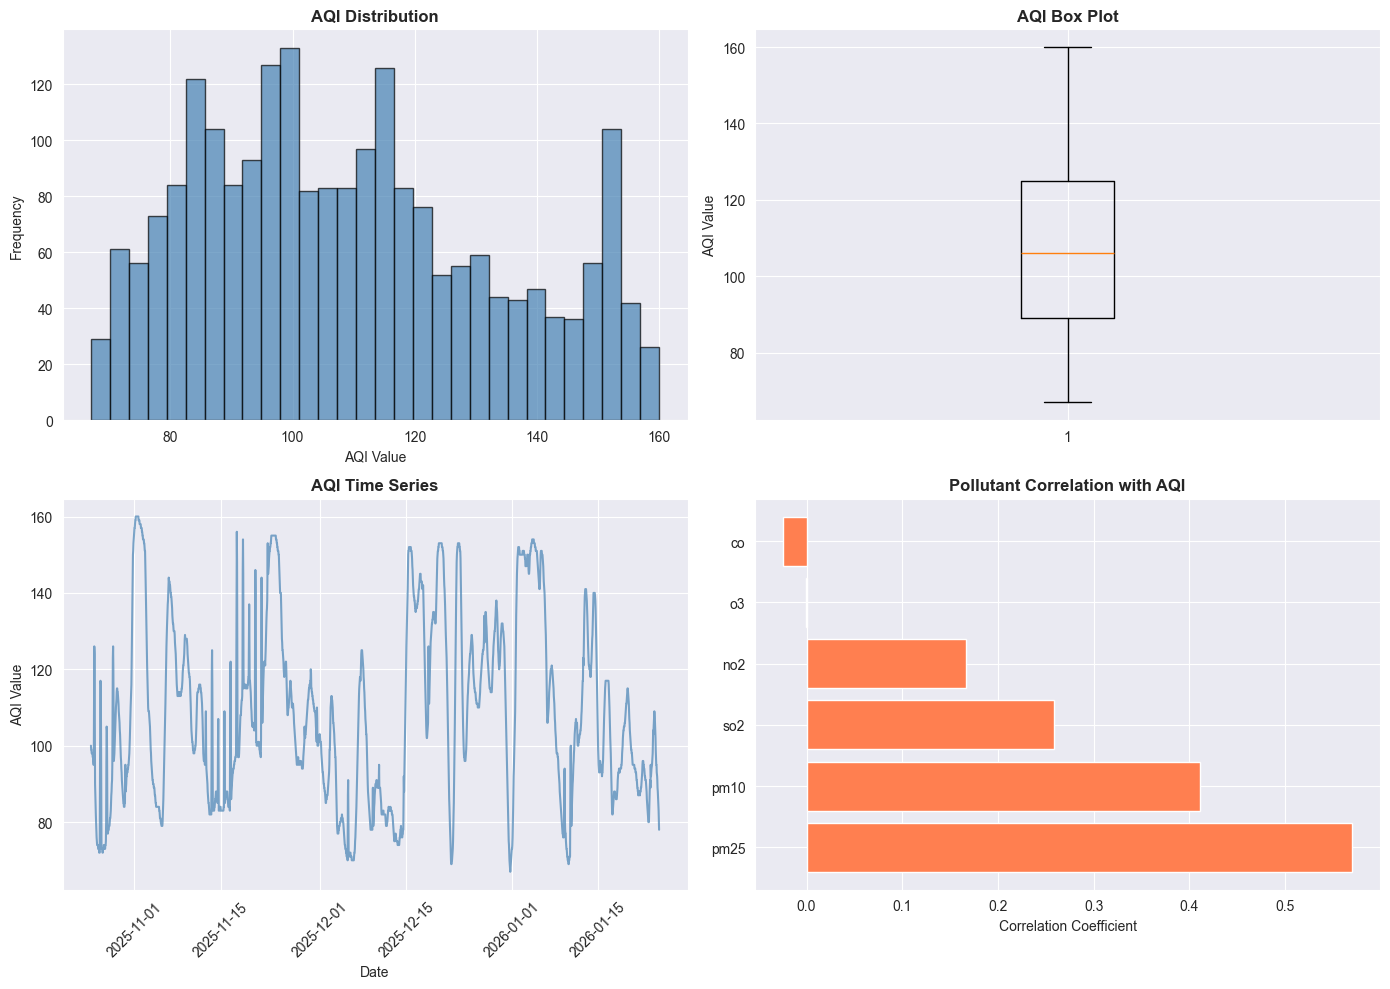


Pollutant Correlations with AQI:
pm25    0.569344
pm10    0.411342
so2     0.258190
no2     0.166468
o3     -0.000079
co     -0.024139
Name: aqi, dtype: float64


In [8]:
# AQI Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
axes[0, 0].hist(df['aqi'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('AQI Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('AQI Value')
axes[0, 0].set_ylabel('Frequency')

# Box plot
axes[0, 1].boxplot(df['aqi'], vert=True)
axes[0, 1].set_title('AQI Box Plot', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('AQI Value')

# Time series
if 'timestamp' in df.columns:
    df_sorted = df.sort_values('timestamp')
    axes[1, 0].plot(df_sorted['timestamp'], df_sorted['aqi'], color='steelblue', alpha=0.7)
    axes[1, 0].set_title('AQI Time Series', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('AQI Value')
    axes[1, 0].tick_params(axis='x', rotation=45)

# Pollutants correlation with AQI
pollutants_with_aqi = pollutants + ['aqi']
corr_with_aqi = df[pollutants_with_aqi].corr()['aqi'].drop('aqi').sort_values(ascending=False)
axes[1, 1].barh(corr_with_aqi.index, corr_with_aqi.values, color='coral')
axes[1, 1].set_title('Pollutant Correlation with AQI', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Correlation Coefficient')

plt.tight_layout()
plt.savefig('../notebooks/plots/eda_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPollutant Correlations with AQI:")
print(corr_with_aqi)

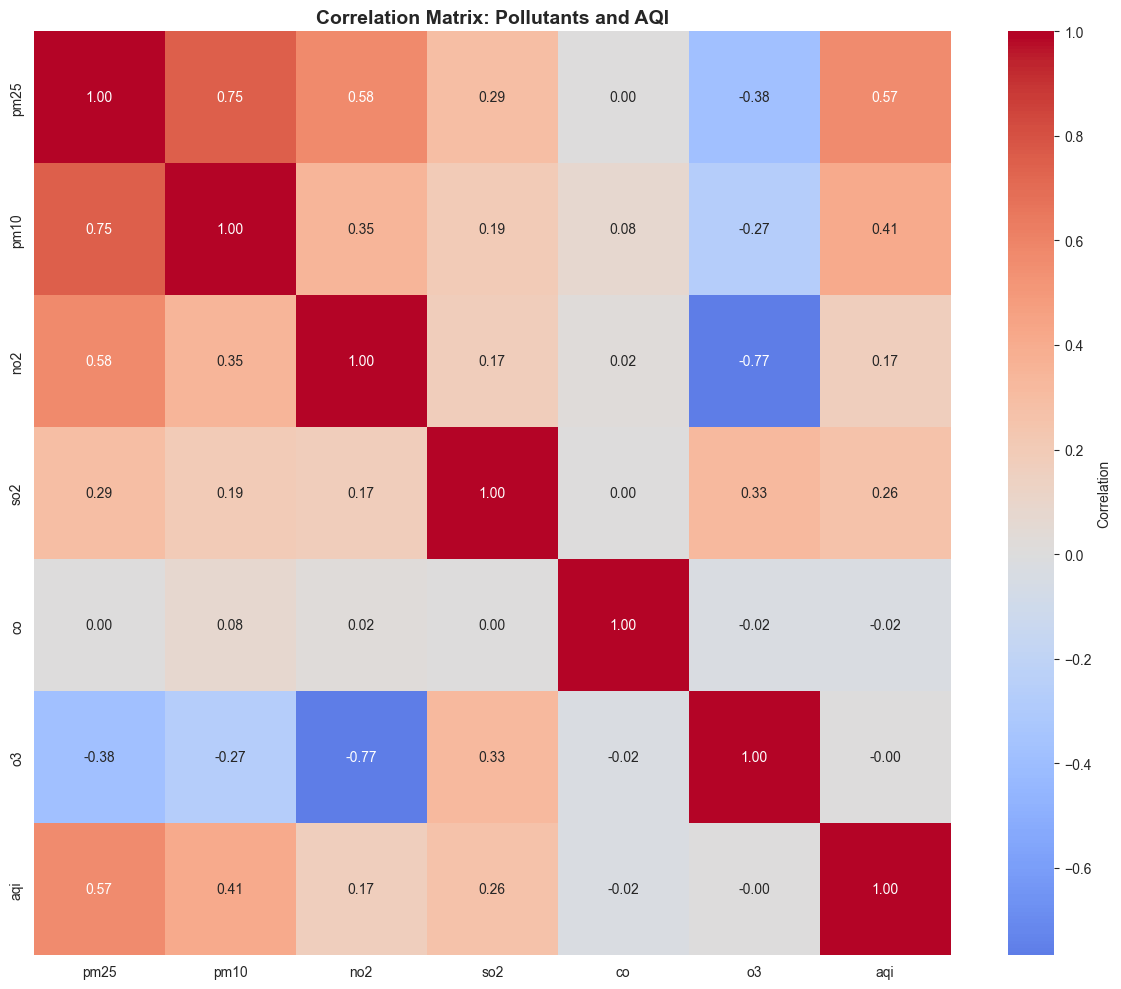

In [9]:
# Correlation matrix heatmap
fig, ax = plt.subplots(figsize=(12, 10))
corr_matrix = df[pollutants_with_aqi].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Matrix: Pollutants and AQI', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../notebooks/plots/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Comprehensive Trend Analysis
print("TREND ANALYSIS - Identifying Patterns")
print("="*80)

# Sort by time
df_sorted = df.sort_values('timestamp')

# Daily trends
df_sorted['date_only'] = pd.to_datetime(df_sorted['timestamp']).dt.date
daily_avg = df_sorted.groupby('date_only')['aqi'].agg(['mean', 'min', 'max', 'std']).reset_index()

print(f"\nDaily Trends:")
print(f"   Average daily mean AQI: {daily_avg['mean'].mean():.1f}")
print(f"   Highest daily average: {daily_avg['mean'].max():.1f} on {daily_avg.loc[daily_avg['mean'].idxmax(), 'date_only']}")
print(f"   Lowest daily average: {daily_avg['mean'].min():.1f} on {daily_avg.loc[daily_avg['mean'].idxmin(), 'date_only']}")
print(f"   Average daily variability (std): {daily_avg['std'].mean():.1f}")

# Hourly patterns
if 'hour' in df_sorted.columns:
    hourly_avg = df_sorted.groupby('hour')['aqi'].mean()
    print(f"\nHourly Patterns:")
    print(f"   Peak hour: {hourly_avg.idxmax()}:00 (AQI: {hourly_avg.max():.1f})")
    print(f"   Best hour: {hourly_avg.idxmin()}:00 (AQI: {hourly_avg.min():.1f})")

# Day of week patterns  
if 'day_of_week' in df_sorted.columns:
    dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_avg = df_sorted.groupby('day_of_week')['aqi'].mean()
    print(f"\nDay of Week Patterns:")
    print(f"   Worst day: {dow_names[int(dow_avg.idxmax())]} (AQI: {dow_avg.max():.1f})")
    print(f"   Best day: {dow_names[int(dow_avg.idxmin())]} (AQI: {dow_avg.min():.1f})")

# Monthly trends
if 'month' in df_sorted.columns:
    monthly_avg = df_sorted.groupby('month')['aqi'].mean()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    print(f"\nMonthly Patterns:")
    print(f"   Worst month: {month_names[int(monthly_avg.idxmax())-1]} (AQI: {monthly_avg.max():.1f})")
    print(f"   Best month: {month_names[int(monthly_avg.idxmin())-1]} (AQI: {monthly_avg.min():.1f})")

# Trend direction (recent vs older data)
mid_point = len(df_sorted) // 2
first_half_avg = df_sorted.iloc[:mid_point]['aqi'].mean()
second_half_avg = df_sorted.iloc[mid_point:]['aqi'].mean()
trend = "Increasing" if second_half_avg > first_half_avg else "Decreasing"
change_pct = ((second_half_avg - first_half_avg) / first_half_avg) * 100

print(f"\nOverall Trend:")
print(f"   First half average: {first_half_avg:.1f}")
print(f"   Second half average: {second_half_avg:.1f}")
print(f"   Trend: {trend} ({change_pct:+.1f}%)")

print("="*80)

TREND ANALYSIS - Identifying Patterns

Daily Trends:
   Average daily mean AQI: 109.0
   Highest daily average: 158.9 on 2025-11-01
   Lowest daily average: 73.5 on 2025-12-06
   Average daily variability (std): 7.3

Hourly Patterns:
   Peak hour: 14:00 (AQI: 114.9)
   Best hour: 11:00 (AQI: 107.7)

Day of Week Patterns:
   Worst day: Sunday (AQI: 115.1)
   Best day: Thursday (AQI: 100.1)

Monthly Patterns:
   Worst month: Nov (AQI: 112.9)
   Best month: Oct (AQI: 95.4)

Overall Trend:
   First half average: 105.8
   Second half average: 112.2
   Trend: Increasing (+6.1%)


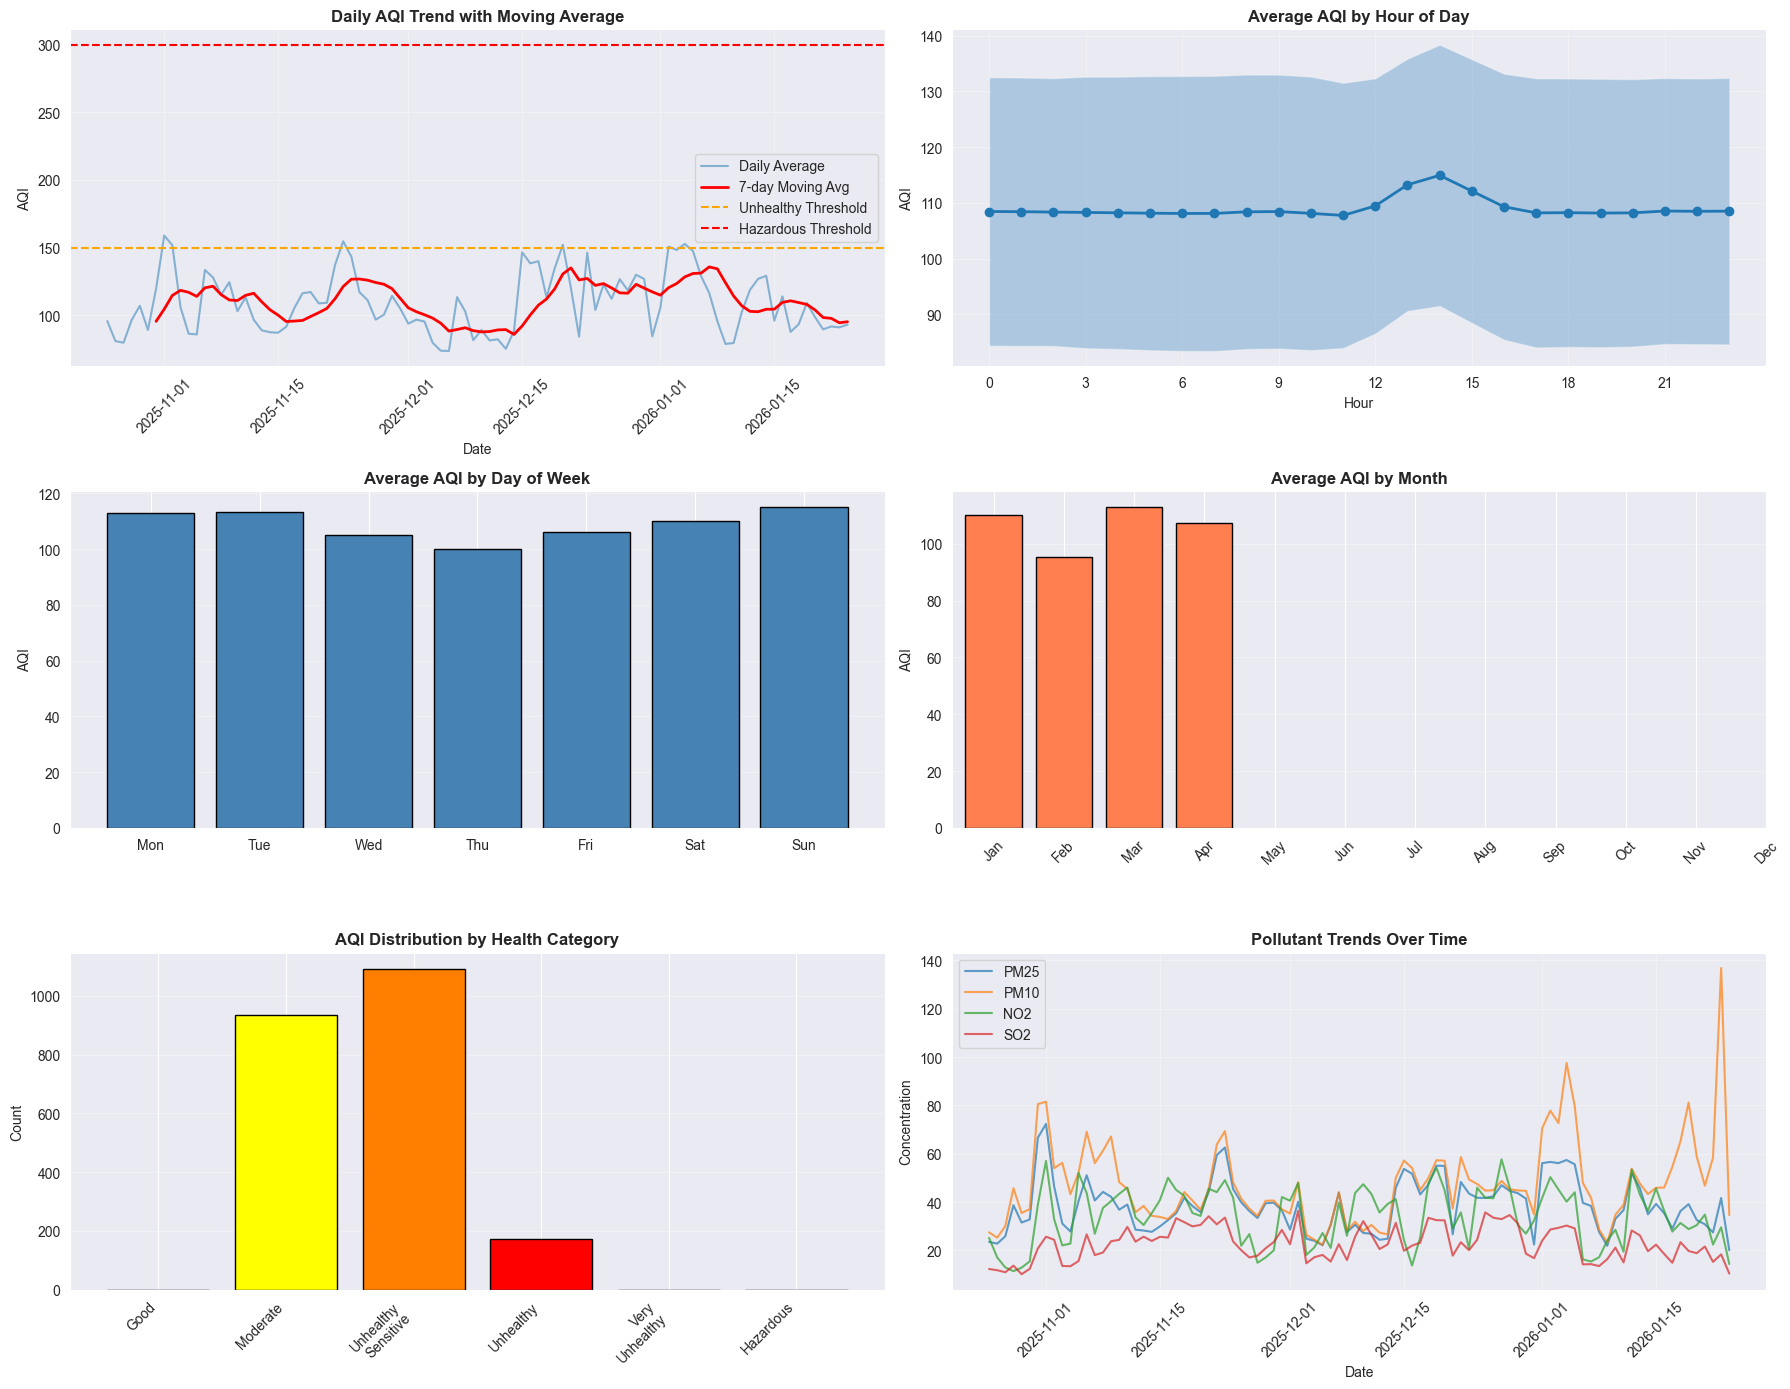

✅ Comprehensive trend analysis plots saved!


In [11]:
# Advanced Trend Visualizations
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

# 1. Daily AQI trend with moving average
df_plot = df_sorted.copy()
daily_aqi = df_plot.groupby('date_only')['aqi'].mean().reset_index()
axes[0, 0].plot(daily_aqi['date_only'], daily_aqi['aqi'], alpha=0.5, label='Daily Average')
axes[0, 0].plot(daily_aqi['date_only'], daily_aqi['aqi'].rolling(window=7).mean(), 
                color='red', linewidth=2, label='7-day Moving Avg')
axes[0, 0].axhline(y=150, color='orange', linestyle='--', label='Unhealthy Threshold')
axes[0, 0].axhline(y=300, color='red', linestyle='--', label='Hazardous Threshold')
axes[0, 0].set_title('Daily AQI Trend with Moving Average', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('AQI')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# 2. Hourly pattern (if available)
if 'hour' in df_plot.columns:
    hourly_pattern = df_plot.groupby('hour')['aqi'].agg(['mean', 'std']).reset_index()
    axes[0, 1].plot(hourly_pattern['hour'], hourly_pattern['mean'], marker='o', linewidth=2)
    axes[0, 1].fill_between(hourly_pattern['hour'], 
                             hourly_pattern['mean'] - hourly_pattern['std'],
                             hourly_pattern['mean'] + hourly_pattern['std'],
                             alpha=0.3)
    axes[0, 1].set_title('Average AQI by Hour of Day', fontweight='bold', fontsize=12)
    axes[0, 1].set_xlabel('Hour')
    axes[0, 1].set_ylabel('AQI')
    axes[0, 1].set_xticks(range(0, 24, 3))
    axes[0, 1].grid(True, alpha=0.3)

# 3. Day of week pattern
if 'day_of_week' in df_plot.columns:
    dow_pattern = df_plot.groupby('day_of_week')['aqi'].mean().reset_index()
    dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    axes[1, 0].bar(dow_names, dow_pattern['aqi'], color='steelblue', edgecolor='black')
    axes[1, 0].set_title('Average AQI by Day of Week', fontweight='bold', fontsize=12)
    axes[1, 0].set_ylabel('AQI')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Monthly pattern
if 'month' in df_plot.columns:
    monthly_pattern = df_plot.groupby('month')['aqi'].mean().reset_index()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    axes[1, 1].bar(range(1, len(monthly_pattern)+1), monthly_pattern['aqi'], 
                   color='coral', edgecolor='black')
    axes[1, 1].set_title('Average AQI by Month', fontweight='bold', fontsize=12)
    axes[1, 1].set_ylabel('AQI')
    axes[1, 1].set_xticks(range(1, 13))
    axes[1, 1].set_xticklabels([month_names[i-1] for i in range(1, 13)], rotation=45)
    axes[1, 1].grid(True, alpha=0.3, axis='y')

# 5. AQI distribution by category
aqi_categories = pd.cut(df_plot['aqi'], 
                        bins=[0, 50, 100, 150, 200, 300, 500],
                        labels=['Good', 'Moderate', 'Unhealthy\nSensitive', 
                                'Unhealthy', 'Very\nUnhealthy', 'Hazardous'])
category_counts = aqi_categories.value_counts().sort_index()
colors_cat = ['#00e400', '#ffff00', '#ff7e00', '#ff0000', '#8f3f97', '#7e0023']
axes[2, 0].bar(range(len(category_counts)), category_counts.values, 
               color=colors_cat[:len(category_counts)], edgecolor='black')
axes[2, 0].set_xticks(range(len(category_counts)))
axes[2, 0].set_xticklabels(category_counts.index, rotation=45, ha='right')
axes[2, 0].set_title('AQI Distribution by Health Category', fontweight='bold', fontsize=12)
axes[2, 0].set_ylabel('Count')
axes[2, 0].grid(True, alpha=0.3, axis='y')

# 6. Pollutants trend (if available)
available_pollutants = [p for p in ['pm25', 'pm10', 'no2', 'so2', 'co', 'o3'] if p in df_plot.columns]
if available_pollutants:
    for pollutant in available_pollutants[:4]:  # Plot first 4 pollutants
        daily_poll = df_plot.groupby('date_only')[pollutant].mean().reset_index()
        axes[2, 1].plot(daily_poll['date_only'], daily_poll[pollutant], 
                       label=pollutant.upper(), alpha=0.7)
    axes[2, 1].set_title('Pollutant Trends Over Time', fontweight='bold', fontsize=12)
    axes[2, 1].set_xlabel('Date')
    axes[2, 1].set_ylabel('Concentration')
    axes[2, 1].legend()
    axes[2, 1].tick_params(axis='x', rotation=45)
    axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../notebooks/plots/comprehensive_trend_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive trend analysis plots saved!")

## Section 3: Prepare Features and Generate Predictions

In [12]:
# Prepare features using the same approach as model training
print("Preparing features...")

# Use the same column exclusion as ModelTrainer
exclude_cols = ['aqi', 'timestamp', 'date', '_id', 'inserted_at', 
                'station_name', 'latitude', 'longitude']

# Use features that the model was trained on (from feature_names.json)
# Only use columns that exist in both feature_names and df
available_features = [f for f in feature_names if f in df.columns]

if not available_features:
    print(f"[WARN] No matching features. Falling back to numeric columns...")
    available_features = [col for col in df.columns 
                         if col not in exclude_cols 
                         and df[col].dtype in ['int64', 'float64']]

print(f"Using {len(available_features)} features: {available_features[:5]}...")

# Create feature matrix directly from DataFrame columns
X = df[available_features].copy()
X = X.fillna(X.median(numeric_only=True))
y = df['aqi'].values

print(f"[OK] Feature matrix shape: {X.shape}")
print(f"[OK] Target shape: {y.shape}")

# Update feature_names to match what we're using
feature_names = available_features

Preparing features...
Using 11 features: ['hour', 'day', 'month', 'year', 'day_of_week']...
[OK] Feature matrix shape: (2197, 11)
[OK] Target shape: (2197,)


## Section 4: Deep Learning Models (LSTM & Neural Network) + Lime Feature Importance

Training data shape: (1757, 11)
Test data shape: (440, 11)

[SUCCESS] All models trained!
Processing Deep Neural Network (MLP)...
[OK] Deep Neural Network (MLP) - Top 10 Features:
               Feature    Importance
0                 year  53324.925160
1             humidity    240.258540
2          temperature    187.552996
3                  day    132.914458
4         12.00 < hour     98.438388
5  22.50 < temperature     96.656294
6    8.00 < wind_speed     96.497437
7          6.00 < hour     55.086448
8    5.80 < wind_speed     54.969849
9         1.00 < month     52.445383

Processing Advanced Gradient Boosting...
[OK] Advanced Gradient Boosting - Top 10 Features:
              Feature  Importance
0        1.00 < month    6.941977
1  3.00 < day_of_week    2.551869
2                hour    0.463518
3          wind_speed    0.422309
4   0.00 < is_weekend    0.365567
5        12.00 < hour    0.347487
6   5.80 < wind_speed    0.304293
7    33.00 < humidity    0.291112
8             

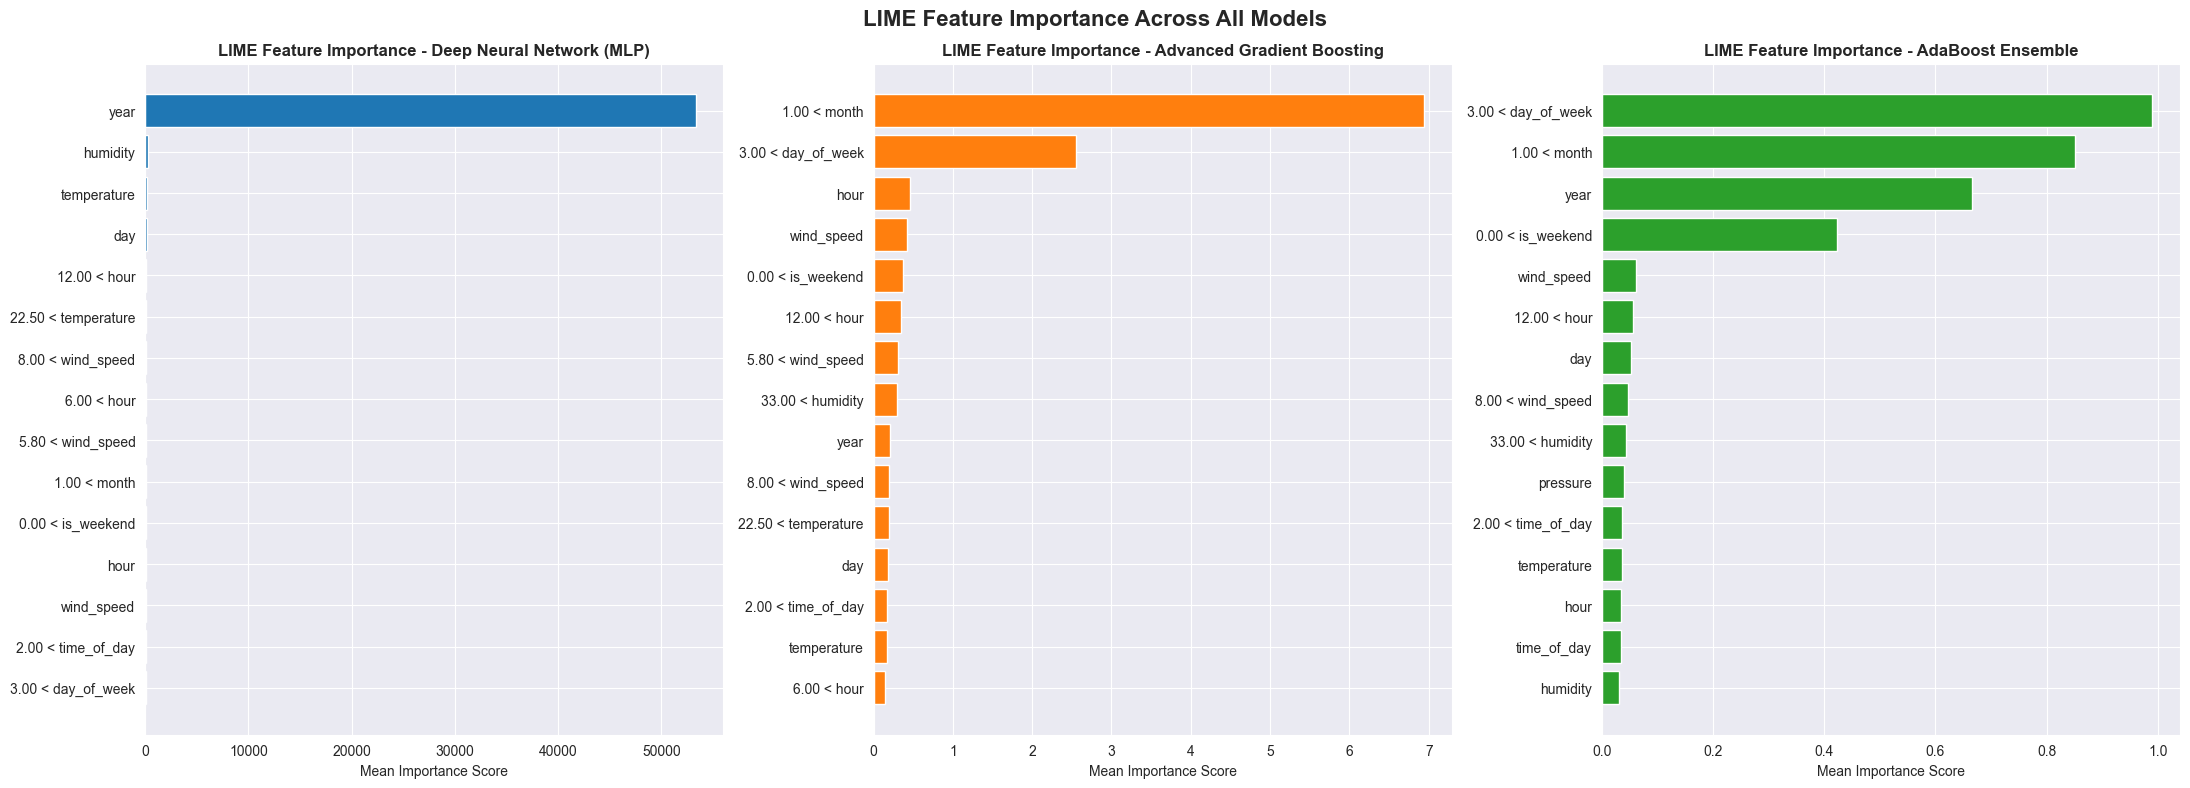

LIME importance plots saved!


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

import lime
import lime.lime_tabular

# One-hot encode categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")

models = {}

# MLP
dnn_model = MLPRegressor(hidden_layer_sizes=(128,64,32,16),
                         activation='relu',
                         solver='adam',
                         max_iter=500,
                         early_stopping=True,
                         validation_fraction=0.2,
                         random_state=42,
                         verbose=False)
dnn_model.fit(X_train_scaled, y_train)
models['Deep Neural Network (MLP)'] = dnn_model

# Gradient Boosting 
gb_model = GradientBoostingRegressor(n_estimators=500,
                                     max_depth=7,
                                     learning_rate=0.05,
                                     subsample=0.8,
                                     random_state=42)
gb_model.fit(X_train_scaled, y_train)
models['Advanced Gradient Boosting'] = gb_model

# AdaBoost 
ada_model = AdaBoostRegressor(n_estimators=200,
                              learning_rate=0.1,
                              random_state=42)
ada_model.fit(X_train_scaled, y_train)
models['AdaBoost Ensemble'] = ada_model

print("\n[SUCCESS] All models trained!")

# 3. LIME Feature Importance

lime_results = {}
X_numeric = X_encoded.values
feature_names = X_encoded.columns.tolist()

for model_name, model in models.items():
    print(f"Processing {model_name}...")
    try:
        explainer = lime.lime_tabular.LimeTabularExplainer(
            X_numeric,
            feature_names=feature_names,
            mode='regression',
            verbose=False
        )
        
        lime_importances = []
        sample_size = min(20, X_numeric.shape[0])
        
        for i in range(sample_size):
            exp = explainer.explain_instance(X_numeric[i], model.predict, num_features=len(feature_names))
            for feature_str, weight in exp.as_list():
                # Clean feature name from LIME string
                feature_name = feature_str.split(' <=')[0].split(' >')[0]
                lime_importances.append({'Feature': feature_name, 'Weight': abs(weight)})
        
        importance_df = pd.DataFrame(lime_importances)
        importance_df = importance_df.groupby('Feature')['Weight'].mean().sort_values(ascending=False).reset_index()
        importance_df.columns = ['Feature', 'Importance']
        lime_results[model_name] = importance_df
        
        print(f"[OK] {model_name} - Top 10 Features:")
        print(importance_df.head(10))
        print()
    except Exception as e:
        print(f"[FAIL] Error with {model_name}: {e}")


# 4. Plot LIME Feature Importance

fig, axes = plt.subplots(1, 3, figsize=(22, 8))

for idx, (model_name, importance_df) in enumerate(lime_results.items()):
    top_features = importance_df.head(15)
    axes[idx].barh(top_features['Feature'], top_features['Importance'], color=f'C{idx}')
    axes[idx].set_xlabel('Mean Importance Score')
    axes[idx].set_title(f'LIME Feature Importance - {model_name}', fontweight='bold')
    axes[idx].invert_yaxis()

plt.suptitle('LIME Feature Importance Across All Models', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../notebooks/plots/lime_importance_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("LIME importance plots saved!")
